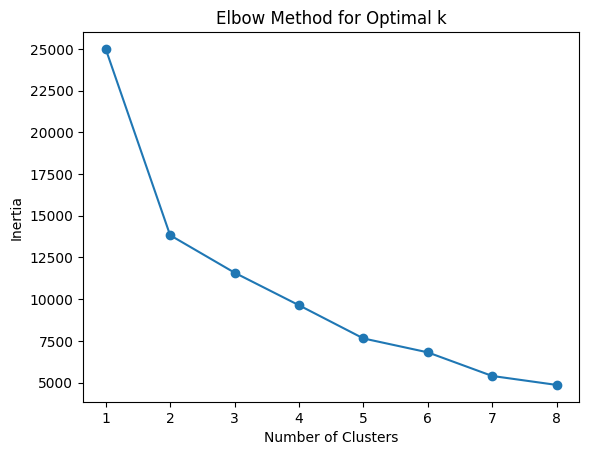

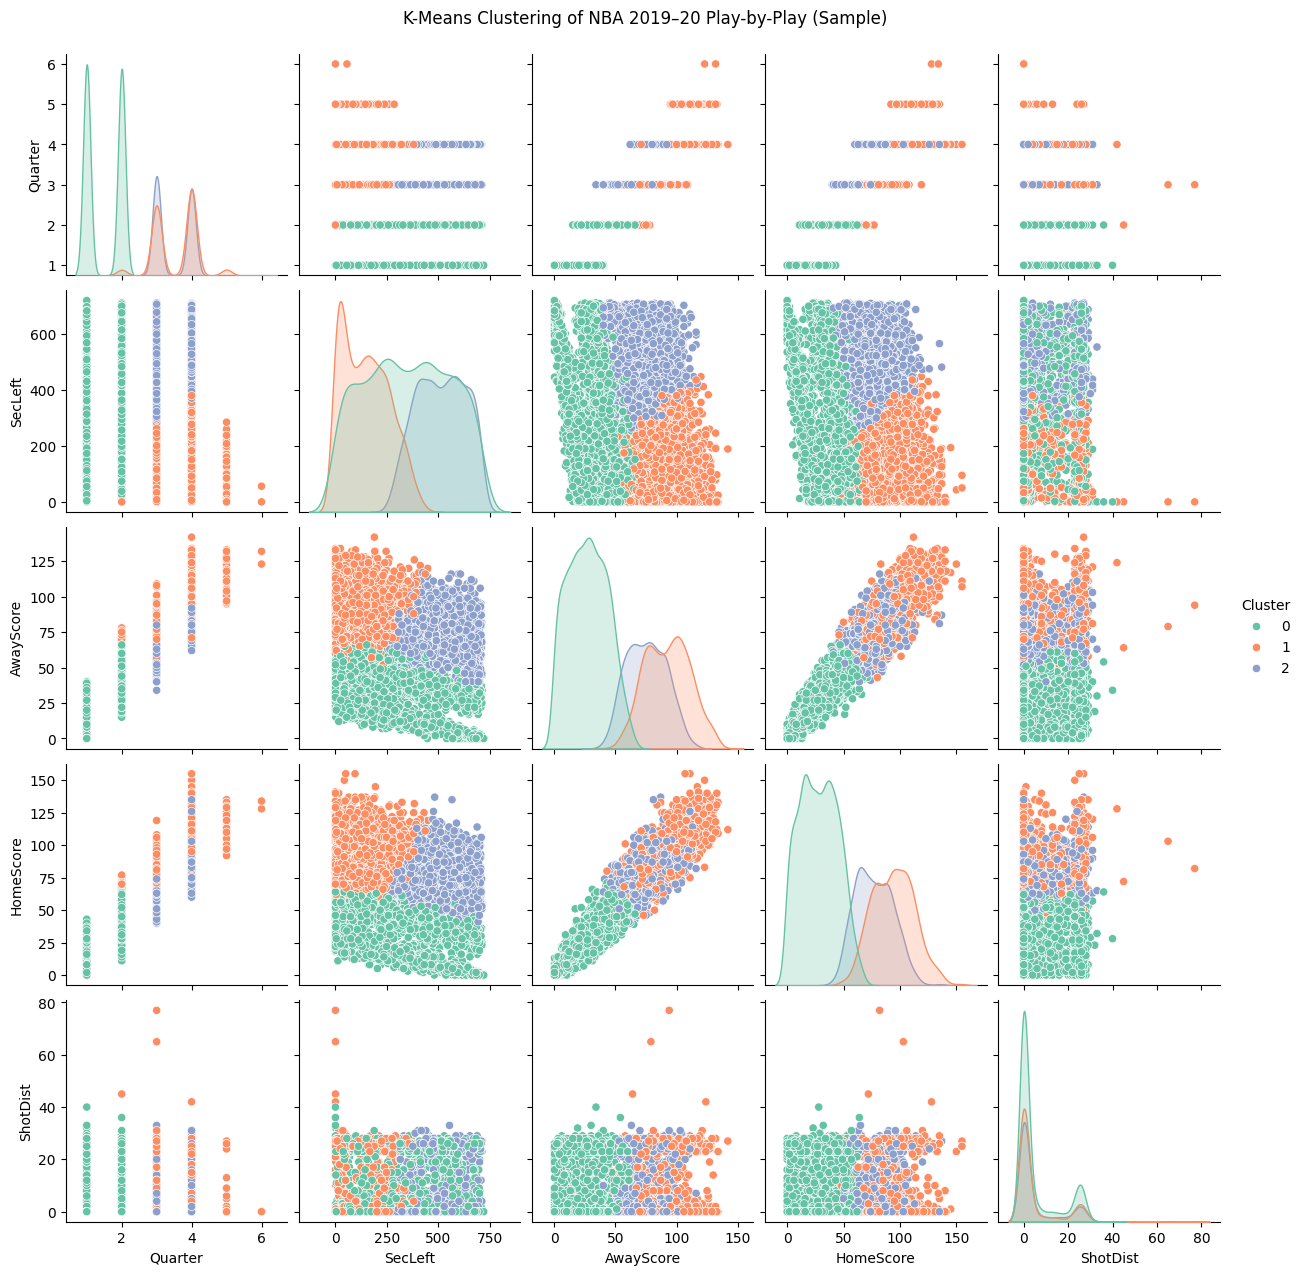

📌 Cluster Centers (scaled):
[[-0.91399179  0.07094375 -0.88098077 -0.87834948  0.02614375]
 [ 0.8905634  -0.89052703  1.06724054  1.05868487 -0.03353193]
 [ 0.81067272  0.84048446  0.55170103  0.55595722 -0.01432557]]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Load the file
file_path = "/content/2019-20_pbp (1).csv"
df = pd.read_csv(file_path)

# Select numeric features relevant for clustering
features = ['Quarter', 'SecLeft', 'AwayScore', 'HomeScore', 'ShotDist']
df_clustering = df[features].copy()

# Drop rows with all NaNs in selected columns and fill remaining NaNs with 0
df_clustering = df_clustering.dropna(how='all')
df_clustering = df_clustering.fillna(0)

# SAMPLE the data for faster clustering
df_clustering = df_clustering.sample(n=5000, random_state=42)

# Normalize the features
scaler = StandardScaler()
scaled = scaler.fit_transform(df_clustering)

# Elbow plot to find optimal k
inertia = []
k_range = range(1, 9)
for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(scaled)
    inertia.append(model.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# Apply KMeans with chosen k (e.g., k=3)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df_clustering['Cluster'] = kmeans.fit_predict(scaled)

# Visualize clusters
sns.pairplot(df_clustering, hue='Cluster', palette='Set2')
plt.suptitle("K-Means Clustering of NBA 2019–20 Play-by-Play (Sample)", y=1.02)
plt.show()


print(" Cluster Centers (scaled):")
print(kmeans.cluster_centers_)


In [ ]:
def get_box_scores(seasons):
    box_scores = {}
    headers = {"User-Agent": "Mozilla/5.0"}
    for season in seasons:
        print(f"Getting monthly links for {season}...")
        season_url = f"https://www.basketball-reference.com/leagues/NBA_{season}_games.html"
        season_page = requests.get(season_url, headers=headers)
        soup = BeautifulSoup(season_page.text, 'html.parser')
        month_links = [a['href'] for a in soup.select('div#content a[href*="_games-"]')]

        print("Month links found:", month_links)

        for link in month_links:
            month_url = f"https://www.basketball-reference.com{link}"
            month = link.split('/')[-1].split('.')[0].split('_')[-1]
            print(f"Scraping games from {month} {season}...")
            page = requests.get(month_url, headers=headers)
            month_soup = BeautifulSoup(page.text, 'html.parser')
            game_links = month_soup.select('td[data-stat="box_score_text"] a')
            urls = [f"https://www.basketball-reference.com{a['href']}" for a in game_links]
            box_scores[f"{season}-{month}"] = urls
            time.sleep(1)

    with open("box_scores.pkl", "wb") as f:
        pickle.dump(box_scores, f)
    return box_scores

In [ ]:
def extract_team_stats_from_boxscore(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    stats = []

    for team_id in ['vis', 'home']:
        table_id = f"box-{team_id}-game-basic"
        table = soup.find("table", {"id": table_id})
        if table is None:
            continue
        row = table.find("tfoot").find("tr")

        def val(stat):
            cell = row.find("td", {"data-stat": stat})
            return float(cell.text.strip()) if cell and cell.text.strip() else np.nan

        stats.append({
            "PTS": val("pts"),
            "REB": val("trb"),
            "AST": val("ast"),
            "TOV": val("tov"),
            "FG%": val("fg_pct"),
            "3P%": val("fg3_pct"),
            "FT%": val("ft_pct")
        })

    return stats

In [ ]:
def scrape_game_stats(box_scores):
    all_stats = []
    urls = [url for sublist in box_scores.values() for url in sublist]

    if not urls:
        print(" No game URLs found — skipping scraping.")
        return pd.DataFrame()

    for i, url in enumerate(urls):
        try:
            teams = extract_team_stats_from_boxscore(url)
            all_stats.extend(teams)
        except Exception as e:
            print(f"Error at {url}: {e}")
        if (i + 1) % 100 == 0:
            print(f"Scraped {i + 1}/{len(urls)} games")

    df = pd.DataFrame(all_stats).dropna()
    df = df.apply(pd.to_numeric, errors='coerce').dropna()
    if not df.empty:
        df.to_csv("nba_team_game_stats.csv", index=False)
        print(" Data saved to nba_team_game_stats.csv")
    else:
        print(" No valid game stats found, nothing to save.")
    return df

In [ ]:
df = scrape_game_stats(box_scores)
print(f"Scraped dataframe shape: {df.shape}")
print(df.head())  # Check if it has real values

📦 Found 0 total game URLs
🧮 Extracted stats for 0 team entries
📊 DataFrame shape before dropna: (0, 0)
🧼 DataFrame shape after dropna: (0, 0)
🚫 No valid game stats found, nothing to save.
Scraped dataframe shape: (0, 0)
Empty DataFrame
Columns: []
Index: []


In [ ]:
def run_kmeans_clustering(df):
    if df.empty:
        print(" DataFrame is empty — skipping KMeans clustering.")
        return

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.values)

    # Elbow method
    inertia = []
    k_range = range(1, 9)
    for k in k_range:
        model = KMeans(n_clusters=k, random_state=42)
        model.fit(scaled_data)
        inertia.append(model.inertia_)

    plt.plot(k_range, inertia, marker='o')
    plt.title("Elbow Method for Optimal k")
    plt.xlabel("Number of clusters")
    plt.ylabel("Inertia")
    plt.show()

    # Choose k=3 for example
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['Cluster'] = kmeans.fit_predict(scaled_data)

    sns.pairplot(df, hue='Cluster', palette='Set2')
    plt.suptitle("K-Means Clustering of Game Stats", y=1.02)
    plt.show()

In [ ]:
if __name__ == "__main__":
    seasons = list(range(2017, 2024))

    try:
        with open("box_scores.pkl", "rb") as f:
            box_scores = pickle.load(f)
            print(" Loaded box_scores.pkl with", sum(len(v) for v in box_scores.values()), "total game URLs.")
        if sum(len(v) for v in box_scores.values()) == 0:
            raise ValueError("Loaded box_scores.pkl but it contains no URLs.")
    except Exception as e:
        print(f" Falling back to scraping due to: {e}")
        box_scores = get_box_scores(seasons)

    df = scrape_game_stats(box_scores)
    run_kmeans_clustering(df)




✅ Loaded box_scores.pkl with 0 total game URLs.
⚠️ Falling back to scraping due to: Loaded box_scores.pkl but it contains no URLs.
Getting monthly links for 2017...
Month links found: []
Getting monthly links for 2018...
Month links found: []
Getting monthly links for 2019...
Month links found: []
Getting monthly links for 2020...
Month links found: []
Getting monthly links for 2021...
Month links found: []
Getting monthly links for 2022...
Month links found: []
Getting monthly links for 2023...
Month links found: []
❌ No game URLs found — skipping scraping.
❌ DataFrame is empty — skipping KMeans clustering.
